In [1]:
import sys

## This to get the peerless target star DataFrame for example purposes
#sys.path.append('/u/tdm/repositories/peerless/prediction')
#sys.path.append('/u/tdm/repositories/peerless')
#from targets import targets


import pandas as pd
targets = pd.read_hdf('targets.h5')

# Sanitize dtypes of targets DataFrame
for c in targets.columns:
    if targets[c].dtype == object:
        targets.loc[:,c] = targets.loc[:,c].astype(str)


# The action is here. Depends on vespa & isochrones.
from exosyspop.populations import KeplerBinaryPopulation

In [2]:
pop = KeplerBinaryPopulation(targets, fB=0.4)

In [3]:
# Accessing secondary properties will initialize a secondary simulation,
# calling pop._generate_binaries().  The first time this is called, the
# secondary property regressors get trained.
pop.radius_B

EB: dmag regressor trained, R2=0.999563133137
EB: qR regressor trained, R2=0.999492802596


array([        nan,         nan,         nan, ...,         nan,
        0.63471573,         nan])

In [4]:
pop.save('testpop', overwrite=True)

In [7]:
pop = KeplerBinaryPopulation('testpop')

In [8]:
pop.radius_B

array([        nan,         nan,         nan, ...,         nan,
        0.63471573,         nan])

In [4]:
# subsequent calls are much faster; e.g.
pop._generate_binaries()
print(pop.radius_B)
%timeit pop._generate_binaries()

[ 0.40864961  0.41787574  0.27628832 ...,  0.29279917  0.60313767
  0.13122177]
10 loops, best of 3: 96.7 ms per loop


In [5]:
# If physical accuracy is important, you can also choose to generate binary properties
# directly from the isochrone, but it's a factor of a few slower:
pop._generate_binaries(use_ic=True)
print(pop.radius_B)
%timeit pop._generate_binaries(use_ic=True)

[        nan  0.33306469         nan ...,         nan         nan
         nan]
1 loops, best of 3: 362 ms per loop


In [7]:
# Similarly, accessing orbital properties will generate them
pop.period

array([  6.28572685e+06,   2.28632375e+04,   2.28765433e+03, ...,
         4.59113422e+04,   1.42098463e+07,   4.25721097e+02])

# Synthetic observations

In [9]:
# Now, we can observe and see what we see.  This takes into account
# duty cycle & data span, as well as geometry.
obs = pop.observe()
print(len(obs))
print(obs.columns)
obs.head()

84
Index([u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR', u'b_pri',
       u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan', u'dutycycle',
       u'b_target', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec'],
      dtype='object')


,host,period,ecc,w,inc,a,aR,b_pri,b_sec,k,...,T23_pri,T23_sec,dataspan,dutycycle,b_target,flux_ratio,dilution,n_pri,n_sec,phase_sec
0,3153,129.484872,0.924090,3.683342,1.562058,8.452738e+12,149.848309,0.365319,0.129528,0.657573,...,0.000000,0.022568,1459.789,0.8750,12.441995,0.075144,1,11,12,0.018533
1,6084,17.888648,0.259020,4.725544,1.545415,2.054122e+12,39.603986,1.265411,0.744777,0.437976,...,0.000000,0.000000,1459.789,0.8750,16.627310,0.021948,1,72,68,0.502246
2,6495,6.372333,0.178574,2.336309,1.563346,1.181537e+12,14.990881,0.095795,0.124109,0.510538,...,0.056625,0.072363,1459.789,0.6984,18.011633,0.032885,1,160,153,0.420773
3,7802,14.745000,0.122320,1.058705,1.570133,2.074451e+12,34.262813,0.020219,0.025045,0.745252,...,0.031199,0.038581,1459.789,0.6988,10.682069,0.183112,1,67,73,0.538353
4,16868,1324.872423,0.407945,0.085859,1.570145,3.803832e+13,475.945615,0.249497,0.267586,0.196276,...,0.597188,0.635334,1459.789,0.8752,19.020436,0.001356,1,1,1,0.751582


In [10]:
# This is pretty fast, even when generating a new population each time:
%timeit pop.observe(new=True)

1 loops, best of 3: 209 ms per loop


In [11]:
# Even faster if we only generate new orbits.
%timeit pop.observe(new_orbits=True)

10 loops, best of 3: 78.8 ms per loop


In [12]:
# So we can predict the expected number of observations pretty easily.
import numpy as np
N = 100
n_obs = np.array([len(pop.observe(new_orbits=True)) for i in range(N)])
n_obs.mean(), n_obs.std()

(86.090000000000003, 9.2218165238742404)

In [13]:
# Notice that the above does not yet have trapezoidal parameters.  There are two options to generate these.
# Either we can set the fit_trap parameter, as follows:
obs = pop.observe(fit_trap=True)
print(len(obs))
obs.columns

83


Index([u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR', u'b_pri',
       u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan', u'dutycycle',
       u'b_target', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec', u'trap_dur_pri', u'trap_depth_pri', u'trap_slope_pri',
       u'trap_dur_sec', u'trap_depth_sec', u'trap_slope_sec'],
      dtype='object')

In [14]:
# All things considered, this is still pretty fast if we just need to do it a few times:
%timeit pop.observe(fit_trap=True)

1 loops, best of 3: 571 ms per loop


In [15]:
# However, this is pretty slow if we want to do inference.  To help with this, we can 
# tell it to train & use a regression.  Training only happens once; by default with 10,000 
# synthetic observations.  This takes a minute or so.
obs = pop.observe(regr_trap=True)
print(len(obs))
obs.columns

EB: Depth trained: R2=0.998884328172
EB: Duration trained: R2=0.999454156259
EB: Slope trained: R2=0.995354253342
101


Index([u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR', u'b_pri',
       u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan', u'dutycycle',
       u'b_target', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec', u'trap_dur_pri_regr', u'trap_depth_pri_regr',
       u'trap_slope_pri_regr', u'trap_dur_sec_regr', u'trap_depth_sec_regr',
       u'trap_slope_sec_regr'],
      dtype='object')

In [16]:
# Subsequent calls are much faster
%timeit pop.observe(regr_trap=True)

10 loops, best of 3: 23.4 ms per loop


In [17]:
# Even generating a new stellar population & observing it is pretty quick
%timeit pop.observe(regr_trap=True, new=True)

1 loops, best of 3: 223 ms per loop


In [16]:
# Or again, you can just generate new orbits (rather than new binaries & new orbits)
%timeit pop.observe(regr_trap=True, new_orbits=True)

10 loops, best of 3: 94.1 ms per loop


In [40]:
# Generating the training data used for the trapezoid shape regression above used
# this function, which can be otherwise useful to sample >N random observations 
# from the existing population.  `trap_regr` defaults to `True` here.  
# This function also takes `new` or `new_orbits` keywords.
obs_pop = pop.get_N_observed(N=2000, new_orbits=True)
print(len(obs_pop))
obs_pop.columns

2083


Index([u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR', u'b_pri',
       u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec', u'T14_pri',
       u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan', u'dutycycle',
       u'b_target', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec', u'trap_dur_pri_regr', u'trap_depth_pri_regr',
       u'trap_slope_pri_regr', u'trap_dur_sec_regr', u'trap_depth_sec_regr',
       u'trap_slope_sec_regr'],
      dtype='object')

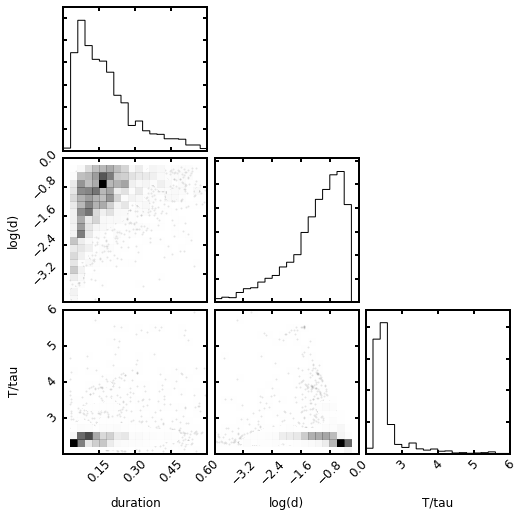

In [45]:
# Let's look at the distribution of trapezoid parameters
%matplotlib inline
from corner import corner

def trap_corner(df, regr=True, **kwargs):

    pri = df.n_pri.values > 0
    sec = (df.n_sec.values > 0) & ~pri
    
    if regr:
        dur = pri*df.trap_dur_pri_regr.fillna(0) + sec*df.trap_dur_sec_regr.fillna(0)
        logd = np.log10(pri*df.trap_depth_pri_regr.fillna(0) + 
                        sec*df.trap_depth_sec_regr.fillna(0))
        slope = pri*df.trap_slope_pri_regr.fillna(0) + sec*df.trap_slope_sec_regr.fillna(0)
    else:
        dur = pri*df.trap_dur_pri.fillna(0) + sec*df.trap_dur_sec.fillna(0)
        logd = np.log10(pri*df.trap_depth_pri.fillna(0) + sec*df.trap_depth_sec.fillna(0))
        slope = pri*df.trap_slope_pri.fillna(0) + sec*df.trap_slope_sec.fillna(0)
        
    #return (dur, logd, slope)
    return corner(np.array([dur, logd, slope]).T, labels=['duration', 'log(d)', 'T/tau'],
                 plot_contours=False, **kwargs)

    
trap_corner(obs_pop, range=[(0,0.6),(-4,0), (2,6)]);

In [42]:
obs_pop2 = pop.get_N_observed(N=2000, new_orbits=True, fit_trap=True)

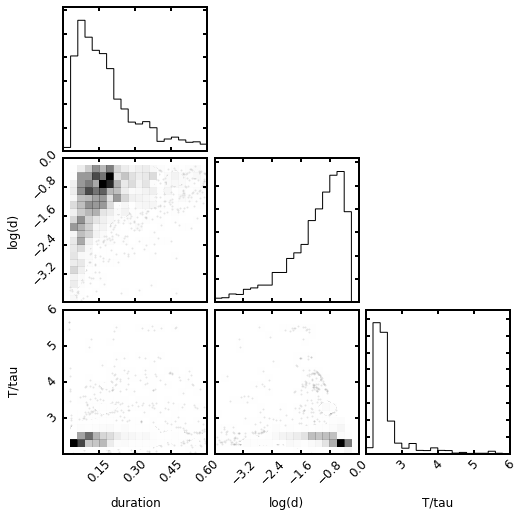

In [46]:
trap_corner(obs_pop2, regr=False, range=[(0,0.6),(-4,0), (2,6)]);

In [18]:
# We can now look, e.g. at the expected number of single/double eclipsing systems:
query = '(n_pri < 3) & (n_sec < 3) & (n_pri==0 | n_sec==0)'
N = 100
n_obs = np.array([len(pop.observe(new_orbits=True).query(query)) for i in range(N)])
n_obs.mean(), n_obs.std()

(4.3399999999999999, 1.8396738841436002)

In [19]:
# Try this again, this time using the empirical eccentricity distribution
# (as opposed to the beta distribution with default params)---eccentricity matters!
pop.ecc_empirical = True
n_obs = np.array([len(pop.observe(new_orbits=True).query(query)) for i in range(N)])
n_obs.mean(), n_obs.std()

(6.2800000000000002, 2.1821090715177367)

In [20]:
# You can also save a trained model so that you can load it back and hit the ground running.
pop.save('ebpop', overwrite=True)
pop = KeplerBinaryPopulation.load('ebpop')

In [21]:
# No training necessary!
pop.observe(regr_trap=True).head()

,host,period,ecc,w,inc,a,aR,b_pri,b_sec,k,...,flux_ratio,n_pri,n_sec,phase_sec,trap_dur_pri_regr,trap_depth_pri_regr,trap_slope_pri_regr,trap_dur_sec_regr,trap_depth_sec_regr,trap_slope_sec_regr
0,1303,1.508235,0.794690,0.908785,0.571017,4.392560e+11,6.760580,1.288318,5.616169,0.495810,...,0.021415,849,0,0.871170,0.044697,0.021101,2.288434,NaN,NaN,NaN
1,1481,1.119021,0.095647,1.220300,1.557535,3.946543e+11,4.311374,0.051982,0.062243,0.645139,...,0.267657,1139,1144,0.520989,0.111869,0.368570,2.405604,0.140385,0.207068,2.538372
2,1704,54.984939,0.687238,1.753266,1.523692,4.608242e+12,60.380019,0.895275,4.628196,0.279898,...,0.003981,22,0,0.392804,0.110049,0.047288,2.554566,NaN,NaN,NaN
3,2426,5.777147,0.086197,4.066556,1.550388,1.162926e+12,18.001832,0.391580,0.341142,0.932021,...,0.769349,175,184,0.466909,0.179252,0.405019,2.298384,0.161438,0.359476,2.288638
4,5496,44.842503,0.808260,4.761843,1.518526,3.995373e+12,87.611478,8.234749,0.878159,0.872604,...,0.376656,0,19,0.543067,NaN,NaN,NaN,0.082805,0.130946,2.359772
